In [1]:
from pymongo import MongoClient
from datetime import datetime
import pandas as pd

### MongoDB

In [2]:
uri = 'mongodb://localhost/'
db = MongoClient(uri)['vendas']

# Recomendação de produtos - Algoritmos Apriori

In [3]:
# dados de 1 ano
d = datetime.now()
cur = db['venda_pedido'].find({'horario':  {'$gte': datetime(d.year - 1, d.month, d.day)}})

qtd = db['venda_estoque'].count_documents({})
pedi = []
for ped in cur:
  itens = []
  for prod in ped['itens_pedido']:
    id = prod['id']
    while len(itens) < id - 1: itens.append(' - ')
    itens.append(f'P{id:02}')
  while len(itens) < qtd: itens.append(' - ')
  pedi.append(itens)

In [4]:
# visualizar
for a in pedi:
  print(a)

[' - ', ' - ', ' - ', ' - ', ' - ', ' - ', ' - ', ' - ', ' - ', ' - ', ' - ', 'P12', ' - ', ' - ', ' - ', ' - ', ' - ', ' - ', ' - ', ' - ', ' - ', ' - ', ' - ', ' - ', ' - ', ' - ', ' - ', ' - ', ' - ']
[' - ', ' - ', ' - ', ' - ', ' - ', ' - ', ' - ', ' - ', ' - ', ' - ', ' - ', ' - ', ' - ', ' - ', ' - ', ' - ', ' - ', ' - ', ' - ', 'P20', ' - ', ' - ', ' - ', ' - ', ' - ', ' - ', ' - ', ' - ', ' - ']
[' - ', ' - ', ' - ', ' - ', ' - ', ' - ', ' - ', ' - ', ' - ', ' - ', ' - ', ' - ', ' - ', ' - ', ' - ', ' - ', ' - ', ' - ', ' - ', ' - ', ' - ', ' - ', 'P23', ' - ', ' - ', 'P26', ' - ', ' - ', ' - ']
[' - ', ' - ', ' - ', ' - ', ' - ', ' - ', 'P07', ' - ', ' - ', ' - ', ' - ', ' - ', ' - ', ' - ', ' - ', ' - ', ' - ', ' - ', ' - ', ' - ', ' - ', ' - ', ' - ', ' - ', ' - ', ' - ', ' - ', ' - ', ' - ']
[' - ', ' - ', ' - ', ' - ', ' - ', ' - ', ' - ', ' - ', ' - ', ' - ', ' - ', ' - ', ' - ', ' - ', ' - ', ' - ', ' - ', ' - ', ' - ', 'P20', ' - ', ' - ', ' - ', ' - ', ' - ', ' - ', '

In [5]:
from apyori import apriori
# regras = list(apriori(pedi, min_support = 0.0006, min_confidence = 0.3, min_lift = 1))
# regras = list(apriori(pedi, min_support = 0.001, min_confidence = 0.1, min_lift = 1))
regras = list(apriori(pedi, min_support = 0.0008, min_confidence = 0.1, min_lift = 1))
# regras = list(apriori(pedi, min_support = 0.0001, min_confidence = 0, min_lift = 0))
# regras = list(apriori(pedi, min_support = 0.00069, min_confidence = 0, min_lift = 0))

it_a = []
it_b = []
# rule = []
supo = []
conf = []
lift = []
for regra in regras:
  for item in regra[2]:
    if ' - ' not in item[0] and ' - ' not in item[1]:
      # rule.append(f"{', '.join(item[0])} > {', '.join(item[1])}")
      it_a.append(','.join(sorted(item[0])))
      it_b.append(','.join(sorted(item[1])))
      supo.append(regra[1])
      conf.append(item[2])
      lift.append(item[3])

df_apriori = pd.DataFrame({
  'item_a': it_a, 
  'item_b': it_b, 
  # 'regra': rule, 
  'suporte': supo, 
  'confianca': conf, 
  'lift': lift
}).sort_values(
  by = ['lift', 'confianca', 'suporte'], 
  ascending = False).reset_index().rename(columns={ 'index': 'id' })
df_apriori


,id,item_a,item_b,suporte,confianca,lift
0,62,"P01,P19",P15,0.001364,0.500000,33.318182
1,63,"P15,P19",P01,0.001364,0.333333,30.541667
2,60,P01,"P15,P19",0.001364,0.125000,30.541667
3,182,"P25,P28","P19,P20",0.001364,0.333333,16.850575
4,179,"P19,P28","P20,P25",0.001364,0.181818,15.679144
...,...,...,...,...,...,...
189,2,,P21,0.190996,0.190996,1.000000
190,4,,P23,0.174625,0.174625,1.000000
191,1,,P20,0.169850,0.169850,1.000000
192,5,,P24,0.137790,0.137790,1.000000


In [6]:
i = 0
j = i + 60
df_apriori[i:j]

,id,item_a,item_b,suporte,confianca,lift
0,62,"P01,P19",P15,0.001364,0.500000,33.318182
1,63,"P15,P19",P01,0.001364,0.333333,30.541667
2,60,P01,"P15,P19",0.001364,0.125000,30.541667
3,182,"P25,P28","P19,P20",0.001364,0.333333,16.850575
4,179,"P19,P28","P20,P25",0.001364,0.181818,15.679144
5,180,"P20,P25","P19,P28",0.001364,0.117647,15.679144
6,189,"P24,P26","P19,P23",0.001364,0.200000,9.773333
7,187,"P19,P26","P23,P24",0.001364,0.153846,8.674556
8,7,P01,P15,0.001364,0.125000,8.329545
9,181,"P20,P28","P19,P25",0.001364,0.166667,8.144444


In [7]:
df_apriori.to_dict('records')

[{'id': 62,
  'item_a': 'P01,P19',
  'item_b': 'P15',
  'suporte': 0.001364256480218281,
  'confianca': 0.5,
  'lift': 33.31818181818181},
 {'id': 63,
  'item_a': 'P15,P19',
  'item_b': 'P01',
  'suporte': 0.001364256480218281,
  'confianca': 0.33333333333333337,
  'lift': 30.54166666666667},
 {'id': 60,
  'item_a': 'P01',
  'item_b': 'P15,P19',
  'suporte': 0.001364256480218281,
  'confianca': 0.125,
  'lift': 30.541666666666668},
 {'id': 182,
  'item_a': 'P25,P28',
  'item_b': 'P19,P20',
  'suporte': 0.001364256480218281,
  'confianca': 0.33333333333333337,
  'lift': 16.85057471264368},
 {'id': 179,
  'item_a': 'P19,P28',
  'item_b': 'P20,P25',
  'suporte': 0.001364256480218281,
  'confianca': 0.18181818181818182,
  'lift': 15.679144385026738},
 {'id': 180,
  'item_a': 'P20,P25',
  'item_b': 'P19,P28',
  'suporte': 0.001364256480218281,
  'confianca': 0.11764705882352942,
  'lift': 15.679144385026738},
 {'id': 189,
  'item_a': 'P24,P26',
  'item_b': 'P19,P23',
  'suporte': 0.00136425

In [8]:
db['venda_apriori'].delete_many({})
db['venda_apriori'].insert_many(df_apriori.to_dict('records'))

InsertManyResult([ObjectId('66522e79eca61dade4c180cd'), ObjectId('66522e79eca61dade4c180ce'), ObjectId('66522e79eca61dade4c180cf'), ObjectId('66522e79eca61dade4c180d0'), ObjectId('66522e79eca61dade4c180d1'), ObjectId('66522e79eca61dade4c180d2'), ObjectId('66522e79eca61dade4c180d3'), ObjectId('66522e79eca61dade4c180d4'), ObjectId('66522e79eca61dade4c180d5'), ObjectId('66522e79eca61dade4c180d6'), ObjectId('66522e79eca61dade4c180d7'), ObjectId('66522e79eca61dade4c180d8'), ObjectId('66522e79eca61dade4c180d9'), ObjectId('66522e79eca61dade4c180da'), ObjectId('66522e79eca61dade4c180db'), ObjectId('66522e79eca61dade4c180dc'), ObjectId('66522e79eca61dade4c180dd'), ObjectId('66522e79eca61dade4c180de'), ObjectId('66522e79eca61dade4c180df'), ObjectId('66522e79eca61dade4c180e0'), ObjectId('66522e79eca61dade4c180e1'), ObjectId('66522e79eca61dade4c180e2'), ObjectId('66522e79eca61dade4c180e3'), ObjectId('66522e79eca61dade4c180e4'), ObjectId('66522e79eca61dade4c180e5'), ObjectId('66522e79eca61dade4c180

# Predição com Prophet

In [9]:
# # dados de 1 ano
# d = datetime.now()
# cur = db['venda_pedido'].find({'horario':  {'$gte': datetime(d.year - 1, d.month, d.day)}})
cur = db['venda_pedido'].find()

df_prophet = pd.DataFrame(cur)[['horario', 'total']].rename(columns={'horario': 'ds', 'total': 'y'}).sort_values(['ds'])
df_prophet

,ds,y
1,2021-01-01 13:10:00,6011.98
2,2021-01-01 13:30:00,1680.93
0,2021-01-01 23:08:00,1265.07
7,2021-01-02 03:49:00,1481.44
4,2021-01-02 09:16:00,3949.12
...,...,...
4870,2024-05-23 20:28:00,1508.16
4872,2024-05-24 12:05:00,115.18
4873,2024-05-24 19:47:00,2951.83
4874,2024-05-25 13:04:00,2178.30


In [10]:
from prophet import Prophet

m = Prophet()
m.fit(df_prophet)

Importing plotly failed. Interactive plots will not work.
15:31:25 - cmdstanpy - INFO - Chain [1] start processing
15:31:25 - cmdstanpy - INFO - Chain [1] done processing


In [11]:
future = m.make_future_dataframe(periods=365)
future.tail()

,ds
5236,2025-05-21 14:19:00
5237,2025-05-22 14:19:00
5238,2025-05-23 14:19:00
5239,2025-05-24 14:19:00
5240,2025-05-25 14:19:00


In [12]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
5236,2025-05-21 14:19:00,4246.770069,-1422.971047,9293.272070
5237,2025-05-22 14:19:00,4237.092789,-972.525676,9600.451709
5238,2025-05-23 14:19:00,4252.676811,-616.801371,10102.365131
5239,2025-05-24 14:19:00,4255.028959,-1339.784591,9959.867300
5240,2025-05-25 14:19:00,4085.670635,-1694.729457,9063.770025


/home/oscar/.local/lib/python3.12/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/home/oscar/.local/lib/python3.12/site-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


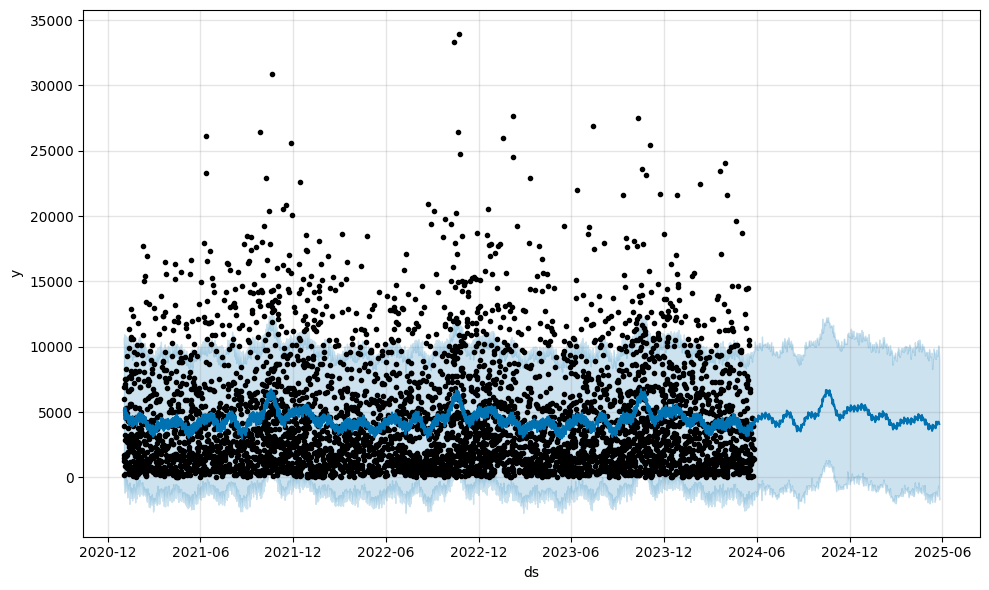

In [13]:
fig1 = m.plot(forecast)

/home/oscar/.local/lib/python3.12/site-packages/prophet/plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/home/oscar/.local/lib/python3.12/site-packages/prophet/plot.py:397: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  artists += ax.plot(df_y['ds'].dt.to_pydatetime(), seas[name], ls='-',
/home/oscar/.local/lib/python3.12/site-packages/prophet/plot.py:401: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the o

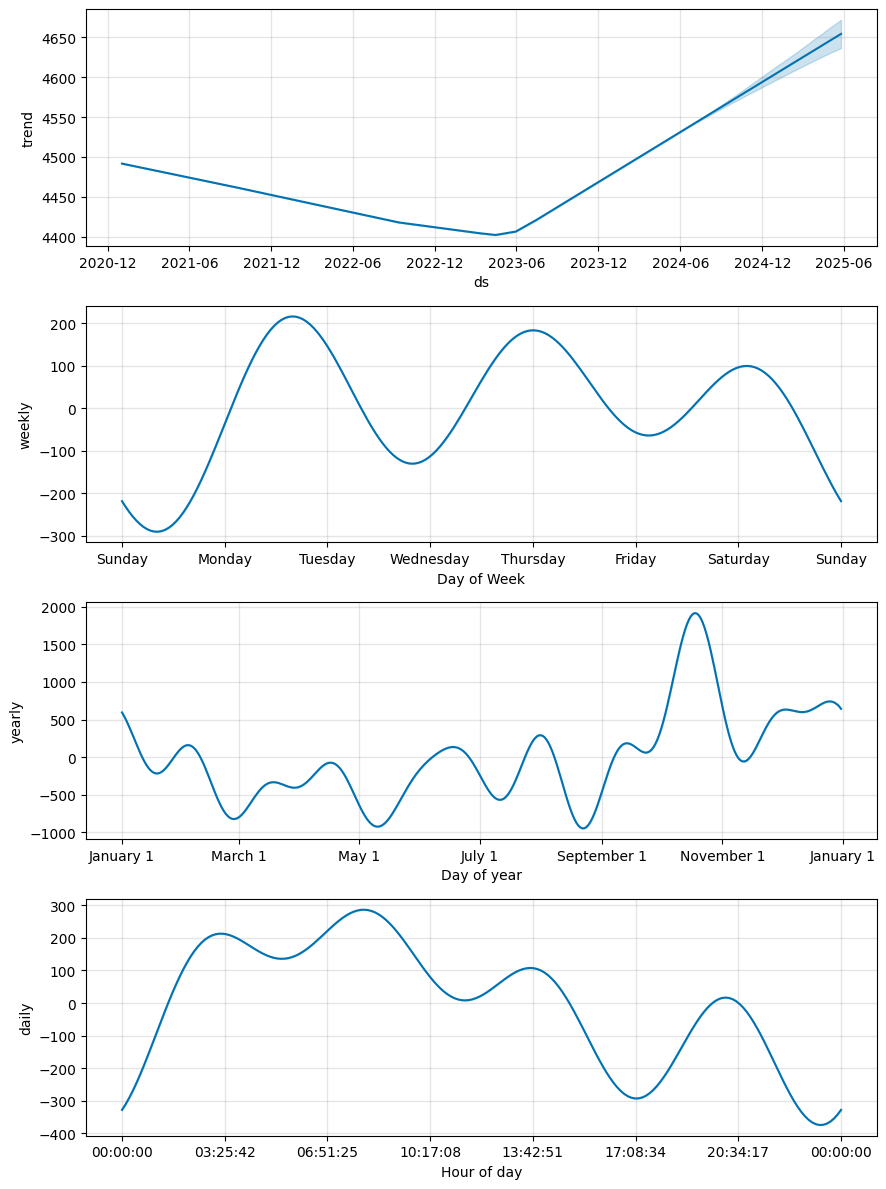

In [14]:
fig2 = m.plot_components(forecast)

In [15]:
fig1.savefig('../home/static/fig1.png')
fig2.savefig('../home/static/fig2.png')